In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
traindf = pd.read_csv('train.csv')
lang = load_model()
lang = lang.top_n_words_model(10000)

In [2]:
from utils import to_input_tensor

In [198]:
# Sample Example from dataset
batch_size = 3
df = traindf[traindf.file_length < 25]
for sents, targets in batch_iter(lang, df, batch_size, shuffle=True):
    break
max(map(len, sents))

23

In [199]:
" ".join([lang.id2word[d] for d in [lang.get_id(w) for w in sents[0]]])

'this movie will always be a broadway and movie classic as long as there are still people who sing dance and act .'

In [200]:
n_embed, embed_size = lang.n_words, 10
embedding = nn.Embedding(n_embed, embed_size)

In [201]:
x, lengths = to_input_tensor(lang, sents, device)
em = embedding(x)
em.shape

torch.Size([23, 3, 10])

In [7]:
" ".join(sents[0])

'as usual sean connery does a great job . lawrence fishburn is good but i have a hard time not seeing him as ike turner .'

In [202]:
hidden_size = 3
gru = nn.GRU(embed_size, hidden_size, bias=True)

In [203]:
x = nn.utils.rnn.pack_padded_sequence(em, lengths)
output, hidden = gru(x)
output, _ = nn.utils.rnn.pad_packed_sequence(output)
output.shape

torch.Size([23, 3, 3])

In [126]:
output.transpose(0, 1)[0].shape

torch.Size([23, 3])

In [103]:
old_attn_mask = torch.ones_like(sent_encoded)
old_attn_mask[0, :] = -float('Inf')

In [104]:
attn.shape, sent_encoded.shape

(torch.Size([3, 26, 26]), torch.Size([3, 26, 3]))

In [188]:
attn_vec = attn.unsqueeze(-1) * sent_encoded
attn_vec = torch.sum(attn_vec, 1)
attn_vec.shape

torch.Size([23, 3])

In [192]:
total_hidden = torch.cat([attn_vec, sent_encoded], dim=1)
total_hidden.shape, total_hidden[0]

(torch.Size([23, 6]),
 tensor([-0.0985, -0.1809,  0.0910, -0.5316, -0.2783,  0.4990],
        grad_fn=<SelectBackward>))

In [131]:
attn.unsqueeze(-1) * sent_encoded, sent_encoded.shape

(tensor([[-0.0000, -0.0000,  0.0000],
         [ 0.0106,  0.0033,  0.0150],
         [ 0.0165,  0.0026,  0.0247],
         [ 0.0221,  0.0076,  0.0154],
         [ 0.0134,  0.0133,  0.0043],
         [ 0.0035, -0.0250, -0.0034],
         [ 0.0163, -0.0103, -0.0057],
         [ 0.0052, -0.0023,  0.0185],
         [ 0.0243, -0.0045,  0.0175],
         [ 0.0117, -0.0337,  0.0093],
         [ 0.0032,  0.0010,  0.0072],
         [ 0.0133,  0.0166, -0.0025],
         [ 0.0139,  0.0137, -0.0042],
         [-0.0316,  0.0124, -0.0029],
         [-0.0768, -0.0651,  0.0015],
         [-0.0375, -0.0340,  0.0034],
         [-0.0180, -0.0215, -0.0003],
         [-0.0614, -0.0607, -0.0004],
         [ 0.0076, -0.0115, -0.0035],
         [ 0.0223, -0.0049, -0.0006],
         [-0.0208,  0.0176,  0.0010],
         [-0.0242,  0.0325,  0.0051],
         [-0.0120, -0.0280, -0.0086]], grad_fn=<MulBackward0>),
 torch.Size([23, 3]))

In [132]:
attn_vec = torch.sum(attn.unsqueeze(-1) * sent_encoded, dim=0)
attn_vec.shape # hidden_dim

torch.Size([3])

In [140]:
total_hidden = torch.cat([attn_vec, word_encoded.squeeze()])
total_hidden, total_hidden.shape

(tensor([-0.0985, -0.1809,  0.0910, -0.5316, -0.2783,  0.4990],
        grad_fn=<CatBackward>), torch.Size([6]))

In [237]:
n_classes = 1
lin = nn.Linear(2 * hidden_size, n_classes)
# torch.sigmoid(lin(total_hidden))

# Sentence Self-Attention RNN

In [111]:
sent_encoded = output.transpose(0, 1)[0]

# Make Attention Mask
attn_mask = torch.eye(max(lengths)) * -float('Inf')
attn_mask[torch.isnan(attn_mask)] = 0
attn_mask[attn_mask == 0] = 1

# Attention MM + Softmax
attn = torch.mm(sent_encoded, sent_encoded.transpose(0, 1))
attn = torch.softmax(attn * attn_mask, dim=1)

# Sum along 
attn_vec = attn.unsqueeze(-1) * sent_encoded
attn_vec = torch.sum(attn_vec, 1)

total_hidden_single = torch.cat([attn_vec, sent_encoded], dim=1)

# Batch Self-Attention RNN

In [170]:
x, lengths = to_input_tensor(lang, sents, device)
lengths

[25, 24, 13]

In [216]:
I = torch.eye(max(lengths))
attn_mask = torch.stack([I] * batch_size)
for i, l in zip(list(range(batch_size)), lengths):
    attn_mask[i, :, l:] = 1
attn_mask

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 1., 1., 1.],
         [0., 0., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])

In [210]:
sent_encoded = output.transpose(0, 1)

attn_mask = torch.eye(max(lengths))

attn = torch.bmm(sent_encoded, sent_encoded.transpose(1, 2))
attn.data.masked_fill_(attn_mask.byte(), -float('inf'))

attn = torch.softmax(attn, dim=2)
attn[torch.isnan(attn)] = 0

attn_vec = attn.unsqueeze(-1) * sent_encoded.unsqueeze(1)
attn_vec = attn_vec.sum(-2)

total_hidden = torch.cat([attn_vec, sent_encoded], dim=-1)
(total_hidden[0] == total_hidden_single).all()

tensor(0, dtype=torch.uint8)

In [46]:
total_hidden = total_hidden.transpose(-1, -2)
total_hidden.shape

torch.Size([3, 6, 26])

In [52]:
max_hidden, idx = torch.max(total_hidden, -1)
max_hidden.unsqueeze(-1).shape

torch.Size([3, 6, 1])

In [91]:
class RNNAttention(nn.Module):
    def __init__(self, language, device, embed_dim, hidden_dim, num_embed, n_classes):
        super().__init__()
        self.device = device
        self.language = language 
        
        self.embedding = nn.Embedding(num_embed, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, bias=True)
        self.classify = nn.Linear(2 * hidden_dim, n_classes)
        
    def forward(self, sents):
        # Embed the sequence
        x, lengths = to_input_tensor(self.language, sents, self.device)
        x_embed = self.embedding(x)
        # RNN encoding
        x = nn.utils.rnn.pack_padded_sequence(x_embed, lengths)
        x, _ = self.gru(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)

        # batch, seq, hidden
        x = x.transpose(0, 1)
        # attention mask 
        attn_mask = torch.eye(max(lengths)) * -float('Inf')
        attn_mask[torch.isnan(attn_mask)] = 0
        attn_mask[attn_mask == 0] = 1

        # apply attention over RNN outputs
        attn = torch.bmm(x, x.transpose(1, 2))
        attn = torch.softmax(attn * attn_mask, dim=2)
        attn[torch.isnan(attn)] = 0
        attn_vec = attn.unsqueeze(-1) * x.unsqueeze(1)
        attn_vec = attn_vec.sum(-2)
        attn_out = torch.cat([attn_vec, x], dim=-1)
        
        # max pool over sequence 
        attn_out = attn_out.transpose(-1, -2)
        max_vec, _ = torch.max(attn_out, -1)
        max_vec = max_vec.unsqueeze(-2)
        
        # binary classification activ.
        y = torch.sigmoid(self.classify(max_vec)).squeeze()
        return y        

# Attention Extraction

In [120]:
from model import *

In [253]:
class RNN_Self_Attention(SaveModel):
    def __init__(self, language, device, batch_size, embed_dim, hidden_dim, num_embed, n_classes):
        super().__init__()
        self.device = device
        self.language = language 
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(num_embed, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, bias=True)
        self.classify = nn.Linear(2 * hidden_dim, n_classes)
        self.attention = RNNAttention()
        
    def forward(self, sents):
        # Embed the sequence
        x, lengths = to_input_tensor(self.language, sents, self.device)
        x_embed = self.embedding(x)
        # RNN encoding
        x = nn.utils.rnn.pack_padded_sequence(x_embed, lengths)
        x, _ = self.gru(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        
        x = x.transpose(0, 1)
        # get attention over RNN outputs 
        I = torch.eye(max(lengths))
        attn_mask = torch.stack([I] * self.batch_size)
        for i, l in zip(list(range(self.batch_size)), lengths):
            attn_mask[i, :, l:] = 1
            attn_mask[i, l:, :] = 1
        
        attn = self.attention(x, attn_mask)
        attn_vec = attn.unsqueeze(-1) * x.unsqueeze(1)
        attn_vec = attn_vec.sum(-2)
        attn_out = torch.cat([attn_vec, x], dim=-1)
        
        # max pool over sequence 
        attn_out = attn_out.transpose(-1, -2)
        max_vec, _ = torch.max(attn_out, -1)
        max_vec = max_vec.unsqueeze(-2)
        
        # binary classification activ.
        y = torch.sigmoid(self.classify(max_vec)).squeeze()
        return y        
    
class RNNAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, attn_mask):
        # apply attention over RNN outputs (batch, seq, hidden)
        attn = torch.bmm(x, x.transpose(1, 2))
        attn.data.masked_fill_(attn_mask.byte(), -float('inf'))
        attn = torch.softmax(attn, dim=2)
        # account for padding 
        attn.data.masked_fill_(attn_mask.byte(), 0)
        return attn

In [254]:
model = RNN_Self_Attention(lang, device, batch_size, 25, 30, lang.n_words, 1)

In [255]:
list(model.modules())

[RNN_Self_Attention(
   (embedding): Embedding(10004, 25)
   (gru): GRU(25, 30)
   (classify): Linear(in_features=60, out_features=1, bias=True)
   (attention): RNNAttention()
 ),
 Embedding(10004, 25),
 GRU(25, 30),
 Linear(in_features=60, out_features=1, bias=True),
 RNNAttention()]

In [256]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

In [257]:
y = model(sents)
hook.remove()

In [258]:
w = tracked_attention_weigths[0]

1.0


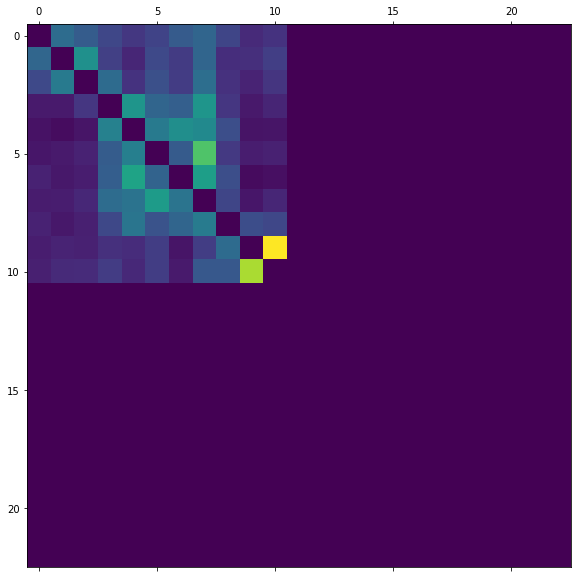

In [263]:
batch_index = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
attention = w.detach().numpy().squeeze()
attention = attention[batch_index] if type(batch_index) == int else attention
ax.matshow(attention, cmap='viridis')
fontdict = {'fontsize': 14}
print(np.sum(attention[0]))

# New Model 

In [177]:
# Sample Example from dataset
batch_size = 3
df = traindf[traindf.file_length < 50]
max_sentence_len = 25
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

24

In [23]:
sentence = sents[0]
target = targets[0]
task = 0 #'<sentiment>'
task = torch.tensor([task] * batch_size)
task.shape

torch.Size([3])

In [81]:
x, lengths = to_input_tensor(lang, sents, device)
x = x.transpose(0, 1)
x.shape

torch.Size([3, 14])

In [82]:
embed_dim = 20
w_embedding = nn.Embedding(lang.n_words, embed_dim)
t_embedding = nn.Embedding(1, hidden_dim)

In [83]:
te = t_embedding(task).unsqueeze(-1)
te.shape

torch.Size([3, 30, 1])

In [59]:
hidden_dim = 30
linear = nn.Linear(embed_dim, hidden_dim)
classify = nn.Linear(hidden_dim, 1)

In [35]:
xe = w_embedding(x)

In [36]:
dropout = 0.3
mha = nn.MultiheadAttention(embed_dim, 1, dropout=dropout)

In [41]:
xa, _ = mha(xe, xe, xe)
x = linear(xa)
x.shape

torch.Size([3, 14, 30])

In [53]:
w = torch.bmm(x, te)
w.shape

torch.Size([3, 14, 1])

In [68]:
torch.softmax(w.squeeze(-1), -1).unsqueeze(-1)[0]

tensor([[3.3235e-06],
        [2.1673e-07],
        [1.1966e-03],
        [2.6087e-04],
        [3.0807e-03],
        [1.4841e-07],
        [7.4762e-01],
        [2.8914e-06],
        [5.5351e-03],
        [5.8624e-07],
        [2.2333e-04],
        [1.6494e-01],
        [2.8781e-06],
        [7.7139e-02]], grad_fn=<SelectBackward>)

In [55]:
weighted_attention = w * x
weighted_attention.shape

torch.Size([3, 14, 30])

In [57]:
wa = weighted_attention.transpose(1, 2)
wa.shape

torch.Size([3, 30, 14])

In [61]:
maxpool, _ = torch.max(wa, -1)
y = torch.sigmoid(classify(maxpool))
y

tensor([[5.2636e-04],
        [4.7082e-02],
        [5.3003e-05]], grad_fn=<SigmoidBackward>)

In [87]:
import torch.nn.functional as F

Updated to Models after june3-851

In [147]:
class TaskSpecificAttention(nn.Module):
    def __init__(self, language, device, embed_dim, hidden_dim, num_embed, num_heads, num_layers, dropout, n_classes):
        super().__init__()
        self.device = device
        self.language = language
        
        self.w_embedding = nn.Embedding(lang.n_words, embed_dim)
        self.t_embedding = nn.Embedding(num_layers, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.mhas, self.linear_1, self.linear_2 = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        self.ln_1, self.ln_2 = nn.ModuleList(), nn.ModuleList()
        self.tasks = []
        self.attention = TaskAttention()
        
        for i in range(num_layers):
            self.mhas.append(nn.MultiheadAttention(embed_dim, 1, dropout=dropout))
            self.linear_1.append(nn.Linear(embed_dim, hidden_dim))
            self.linear_2.append(nn.Linear(hidden_dim, embed_dim))
            self.tasks.append(i)
            
            self.ln_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.ln_2.append(nn.LayerNorm(hidden_dim, eps=1e-12))
        
        self.classify = nn.Linear(embed_dim, n_classes)
        
    def forward(self, sents):
        batch_size = len(sents)
        x, lengths = to_input_tensor(lang, sents, device)
        x = x.transpose(0, 1)
        # bs, seq, embed
        x = self.w_embedding(x)

        for task, mha, linear_1, linear_2, lnorm_1, lnorm_2 in zip(self.tasks, self.mhas, self.linear_1, self.linear_2, self.ln_1, self.ln_2):
            tasks = torch.tensor([task] * batch_size, device=self.device)
            te = self.t_embedding(tasks).unsqueeze(-1)
            
            x = lnorm_1(x)
            # bs, seq, embed
            x, _ = mha(x, x, x)
            # bs, seq, hidden
            x = linear_1(x)
            
            # task attention
            w = self.attention(x, te)
            weighted_attention = w * x
            x = self.dropout(weighted_attention)
            
            x = lnorm_2(x)
            # bs, seq, embed
            x = F.relu(linear_2(x))

        # bs, embed, seq
        x = x.transpose(1, 2)
        maxpool, _ = torch.max(x, -1)
        maxpool = bn
        y = torch.sigmoid(self.classify(maxpool)).squeeze()
        
        return y

In [158]:
n_heads = 1
n_layers = 2
dropout = 0.3 

model = TaskSpecificAttention(lang, device, embed_dim, hidden_dim, lang.n_words, n_heads, n_layers, dropout, 1)

In [159]:
class TaskAttention(SaveModel):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, te):
        # task attention
        w = torch.bmm(x, te)
        w = torch.softmax(w.squeeze(-1), -1).unsqueeze(-1)
        return w

In [ ]:
# Sample Example from dataset
batch_size = 3
df = traindf[traindf.file_length < 50]
max_sentence_len = 25
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

In [178]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

In [179]:
model(sents)
hook.remove()

In [180]:
batch_attn = tracked_attention_weigths[0].detach().numpy().squeeze()

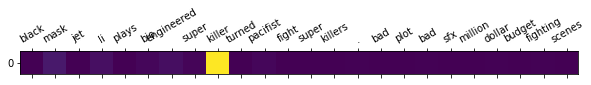

In [195]:
i = 0
attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')
ax.set_xticklabels([''] + sentence, rotation=30)
# ax.set_yticklabels([''] + sentence)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [207]:
batch_size = len(sents)
x, lengths = to_input_tensor(lang, sents, device)
x = x.transpose(0, 1)
# bs, seq, embed
x = w_embedding(x)
x = x.unsqueeze(1)
x.shape

torch.Size([3, 1, 24, 20])

In [212]:
conv = nn.Conv2d(1, 1, 3, stride=2)

In [267]:
x = torch.rand((batch_size, embed_dim, 400))
x.shape

torch.Size([3, 20, 400])

In [268]:
m = nn.MaxPool1d(8)
p = m(x)
p.shape

torch.Size([3, 20, 50])

In [270]:
diff = 100 - p.size(-1)
diff

50

In [277]:
pad = torch.zeros((p.size(0), p.size(1), diff))
pad.require_grad = False
pad.shape

torch.Size([3, 20, 50])

In [288]:
x = torch.cat([p, pad], -1)
x.shape

torch.Size([3, 20, 100])

In [289]:
h1 = nn.Linear(100, hidden_dim)
h2 = nn.Linear(hidden_dim, hidden_dim)
h3 = nn.Linear(embed_dim, 1)
classify = nn.Linear(hidden_dim, n_classes)

In [290]:
x = h1(x)
x = h2(x)
x = h3(x.transpose(-1, -2)).squeeze()
x = classify(x)
x.shape

torch.Size([3, 1])

In [291]:
x

tensor([[-0.2151],
        [-0.2084],
        [-0.2051]], grad_fn=<AddmmBackward>)

# Improving Batcher

In [304]:
import random

In [300]:
# get one file, get `batch_size - 1` other files with file_length within a certain amount of it 
n = 10
batch_size = 64
file_lengths = traindf.file_length.values
tmpdf = traindf.copy()

for (p, t, _, length) in traindf.values:
    lb, ub = length - n, length + n
    # find files lb < _ < ub for file lengths
    idxs = [i for i, fl in enumerate(file_lengths) if (fl >= lb and fl <= ub)]
    
    random.shuffle(idxs)
    idxs = idxs[:batch_size] if len(idxs) > batch_size else idxs
    batchdf = traindf.loc[idxs]
    
    tmpdf = traindf[~traindf.index.isin(batchdf.index)]
    
    break

In [341]:
n = 10
batch_size = 64
file_lengths = traindf.file_length.values
tmpdf = traindf.copy()

while len(tmpdf) > batch_size:
    (_, _, _, length) = tmpdf.values[0]
    lb, ub = length - n, length + n
    file_lengths = tmpdf.file_length.values
    fl_idxs = tmpdf.file_length.index
    idxs = [i for i, fl in zip(fl_idxs, file_lengths) if (fl >= lb and fl <= ub)]
    
    random.shuffle(idxs)
    idxs = idxs[:batch_size] if len(idxs) > batch_size else idxs
    batchdf = tmpdf.loc[idxs]
    
    # remove selected batch rows 
    tmpdf = tmpdf[~tmpdf.index.isin(batchdf.index)]

KeyboardInterrupt: 

In [339]:
tmpdf.file_length.index

Int64Index([    1,     2,     3,     4,     5,     7,     8,     9,    10,
               11,
            ...
            24989, 24990, 24991, 24993, 24994, 24995, 24996, 24997, 24998,
            24999],
           dtype='int64', length=23005)

In [329]:
len(tmpdf), max(idxs)

(10097, 9973)

In [333]:
tmpdf.head()

,path,target,review_rating,file_length
6,train/neg/3351_4.txt,0,4,197
7,train/neg/399_2.txt,0,2,93
8,train/neg/10447_1.txt,0,1,170
9,train/neg/10096_1.txt,0,1,127
10,train/neg/9850_1.txt,0,1,129


In [332]:
tmpdf.loc[idxs[:10]]

KeyError: "None of [Int64Index([6177, 3236, 579, 6441, 9379, 3866, 9102, 9346, 1297, 1872], dtype='int64')] are in the [index]"

In [320]:
(_, _, _, length) = traindf.values[0]
length

41

In [308]:
random.shuffle(idxs)
idxs = idxs[:batch_size] if len(idxs) > batch_size else idxs
len(idxs)

64

In [310]:
batchdf = traindf.loc[idxs]
batchdf.head()

,path,target,review_rating,file_length
11430,train/neg/6255_1.txt,0,1,49
11290,train/neg/3922_3.txt,0,3,51
16213,train/pos/12193_10.txt,1,10,40
18001,train/pos/3884_8.txt,1,8,36
19857,train/pos/8292_8.txt,1,8,42


In [314]:
len(traindf[~traindf.index.isin(batchdf.index)]) == len(traindf) - batch_size

True

In [317]:
updateddf = traindf[~traindf.index.isin(batchdf.index)]

# Glove Embeddings

In [2]:
import bcolz
import pickle
import numpy as np 

from tqdm import tqdm

In [3]:
glove_path = '.'

In [4]:
f = open(f'{glove_path}/glove.840B.300d.txt', 'rb')

In [7]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

with open(f'{glove_path}/glove.840B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split(' ')
        word = line[0]
        if word not in words:
        words.append(word)
        word2idx[word] = idx
        idx += 1
        try:
            vect = np.array(line[1:]).astype(np.float)
        except:
            print(line)
            
        if idx % 10000 == 0: print(idx)
        vectors.append(vect)

In [11]:
vectors = bcolz.carray(vectors[1:].reshape((2196017, 300)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/840B.300_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/840B.300_idx.pkl', 'wb'))

In [15]:
import time

In [16]:
# vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
# words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
# word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

start = time.time()
glove = {w: vectors[word2idx[w]] for w in words}
time.time() - start

25.175731897354126

In [18]:
lang = load_model()

In [24]:
emb_dim = 300
matrix_len = lang.n_words
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0

for i in lang.id2word:
    word = lang.id2word[i]
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [26]:
words_found / lang.n_words

0.798226135783563

In [28]:
weights_matrix.shape, lang.n_words

((78360, 300), 78360)

In [31]:
with open('./glove/imdb_weights.pkl', 'wb') as f:
    weights_matrix.dump(f)

In [34]:
emb_dim = 300
matrix_len = lang.n_words
with open('./glove/imdb_weights.pkl', 'rb') as f:
    weights_matrix = np.load(f, allow_pickle=True)

In [36]:
weights_matrix.shape

(78360, 300)

In [64]:
def glove_embeddings(trainable=False):
    with open('./glove/imdb_weights.pkl', 'rb') as f:
        weights_matrix = np.load(f, allow_pickle=True)
    mtrx = torch.tensor(weights_matrix)
    
    embedding = nn.Embedding(mtrx.size(0), 300)
    embedding.load_state_dict({'weight': mtrx})
    
    if not trainable:
        embedding.requires_grad = False
    return embedding

In [65]:
glove_embeddings()

Embedding(78360, 300)

In [54]:
from language_structure import *

In [55]:
lang = load_model()

In [60]:
tlang = lang.top_n_words_model(10000)

In [61]:
for w in tlang.word2id:
    i = tlang.word2id[w]
    assert i == lang.word2id[w]

# Restricted Attention

In [68]:
# batchsize, seq_len, 1
import torch.nn.functional as F

In [129]:
# start with seq_len values 
seq_len = 5 
w = torch.rand((seq_len, 1))
w = F.softmax(w.squeeze(), -1).unsqueeze(-1)
w

tensor([[0.1268],
        [0.1334],
        [0.2253],
        [0.2560],
        [0.2586]])

In [102]:
w = F.softmax(w.squeeze(), -1)
w

tensor([0.1897, 0.2059, 0.2004, 0.2031, 0.2009])

In [103]:
# n indexs of smallest attention values
restrict_idx = torch.argsort(w)[:n]
w[restrict_idx] = -float('Inf')
F.softmax(w, -1), restrict_idx

(tensor([0.0000, 0.3342, 0.0000, 0.3333, 0.3325]), tensor([0, 2]))

In [131]:
torch.multinomial(w.squeeze(), n)

tensor([1, 0])

In [141]:
# multinomial test
# order by distance from the max value 
w = w.squeeze()
# inverse probability hack for multinomial sampling
p_inv = torch.max(w) - w
w, p_inv, torch.multinomial(p_inv, n)

(tensor([0.1268, 0.1334, 0.2253, 0.2560, 0.2586]),
 tensor([0.1318, 0.1252, 0.0333, 0.0026, 0.0000]),
 tensor([1, 0]))

In [164]:
## BATCH VERSION
# start with seq_len values 
seq_len = 5 
w = torch.rand((2, seq_len, 1))
w = F.softmax(w.squeeze(), -1)
w

tensor([[0.2093, 0.1619, 0.2502, 0.2380, 0.1405],
        [0.2210, 0.1721, 0.2060, 0.1967, 0.2042]])

In [115]:
restrict_idx = torch.argsort(w, -1)
restrict_idx
# w[restrict_idx] = -float('Inf')

tensor([[2, 0, 1, 4, 3],
        [2, 3, 0, 1, 4]])

In [116]:
restrict_idx[:, :n]

tensor([[2, 0],
        [2, 3]])

In [126]:
# apply restricted attention mask
for w_t, mask in zip(torch.split(w, 1), restrict_idx[:, :n]):
    w_t.squeeze()[mask] = -float('Inf')
w

tensor([[  -inf, 0.2018,   -inf, 0.2701, 0.2047],
        [0.1775, 0.1784,   -inf,   -inf, 0.3070]])

In [128]:
F.softmax(w, -1)

tensor([[0.0000, 0.3254, 0.0000, 0.3483, 0.3263],
        [0.3186, 0.3188, 0.0000, 0.0000, 0.3626]])

In [144]:
w, torch.max(w, -1)

(tensor([[0.1455, 0.2532, 0.1438, 0.1501, 0.3074],
         [0.2107, 0.1732, 0.2231, 0.1592, 0.2339]]), torch.return_types.max(
 values=tensor([0.3074, 0.2339]),
 indices=tensor([4, 4])))

In [165]:
# inverse probability hack for multinomial sampling
mx, _ = torch.max(w, -1)
mx = mx.unsqueeze(-1)
mx.shape, w.shape

(torch.Size([2, 1]), torch.Size([2, 5]))

In [166]:
p_inv = mx - w
w, p_inv

(tensor([[0.2093, 0.1619, 0.2502, 0.2380, 0.1405],
         [0.2210, 0.1721, 0.2060, 0.1967, 0.2042]]),
 tensor([[0.0409, 0.0883, 0.0000, 0.0122, 0.1097],
         [0.0000, 0.0489, 0.0150, 0.0243, 0.0168]]))

In [174]:
w.size(-1)

5

In [167]:
attnmask = torch.multinomial(p_inv, n)
attnmask

tensor([[1, 0],
        [1, 3]])

In [168]:
# apply restricted attention mask
for w_t, mask in zip(torch.split(w, 1), attnmask):
    w_t.squeeze()[mask] = -float('Inf')
w

tensor([[  -inf,   -inf, 0.2502, 0.2380, 0.1405],
        [0.2210,   -inf, 0.2060,   -inf, 0.2042]])

In [172]:
# re-weight with softmax
attn = F.softmax(w, -1)
attn

tensor([[0.0000, 0.0000, 0.3467, 0.3425, 0.3107],
        [0.3369, 0.0000, 0.3319, 0.0000, 0.3313]])

# working version - adjusted for training on GPU

In [187]:
## BATCH VERSION
# start with seq_len values 
seq_len = 5 
w = torch.rand((2, seq_len, 1))
w = F.softmax(w.squeeze(), -1)

inf = torch.tensor(float("inf")).to(device)
w

tensor([[0.2286, 0.1687, 0.1031, 0.2528, 0.2468],
        [0.2310, 0.2020, 0.1548, 0.2269, 0.1853]])

In [188]:
# 1 where inf is applied
n = w.size(-1) // 2
# inverse probability hack for multinomial sampling
mx, _ = torch.max(w, -1)
mx = mx.unsqueeze(-1)
p_inv = mx - w
attnmask = torch.multinomial(p_inv, n)
attnmask

tensor([[1, 2],
        [1, 4]])

In [189]:
byte_mask = torch.zeros_like(w)
for bm, mask in zip(torch.split(byte_mask, 1), attnmask):
    bm.squeeze()[mask] = 1
byte_mask, attnmask

(tensor([[0., 1., 1., 0., 0.],
         [0., 1., 0., 0., 1.]]), tensor([[1, 2],
         [1, 4]]))

In [192]:
attn_bytes = byte_mask.byte().to(device)
1 - attn_bytes

tensor([[1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0]], dtype=torch.uint8)

In [191]:
F.softmax(w, -1)

tensor([[0.2055, 0.1935, 0.1812, 0.2105, 0.2092],
        [0.2062, 0.2003, 0.1911, 0.2054, 0.1970]])

# TorchVision Dataset Testing

In [3]:
import torchvision
import torch 
import torchvision.transforms as transforms

In [4]:
dset = torchvision.datasets.MNIST
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
trainset = dset(root='./data', train=True, download=False, transform=transform)
testset = dset(root='./data', train=False, download=False)

In [6]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

In [8]:
from fastai.vision import * 
idb = ImageDataBunch(trainloader, trainloader)
idb.show_batch()

AttributeError: 'MNIST' object has no attribute 'x'

In [57]:
dataiter = iter(trainloader)
img, label = dataiter.next()

In [6]:
label, img.shape

(tensor([0, 5, 6, 9]), torch.Size([4, 1, 28, 28]))

In [7]:
import matplotlib.pyplot as plt

In [8]:
npimg = img.numpy()[0].transpose(1, 2, 0).squeeze()
npimg.shape

(28, 28)

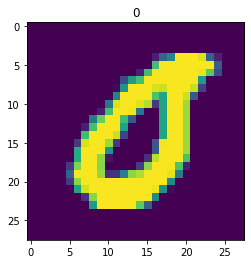

In [9]:
plt.imshow(npimg)
plt.title(label[0].numpy())
plt.show()

In [1]:
from fastai.vision import *

import fastai
import torchvision.transforms as transforms

In [2]:
fastai.__version__

'1.0.52'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
d = unpickle('./cifar-10-batches-py/data_batch_1')

In [16]:
d.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [17]:
class dset(Dataset):
    def __init__(self, data, labels, transforms):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img = self.transforms(self.data[idx])
        return img, self.labels[idx]
    
    def __len__(self):
        return len(self.labels)

In [18]:
databatch1 = d[b'data'].reshape((10000, -1, 32, 32))
databatch1.shape

(10000, 3, 32, 32)

In [22]:
d = dset(databatch1, d[b'labels'], transforms.Compose([transforms.ToTensor()]))

In [23]:
trainloader = torch.utils.data.DataLoader(d, batch_size=4,
                                      shuffle=True, num_workers=0)

In [25]:
idb = ImageDataBunch(trainloader, trainloader)
idb.show_batch()

AttributeError: module 'fastai.vision.data' has no attribute 'ImageDataBunch'

In [95]:
ex = databatch1[2].transpose(1, 2, 0)

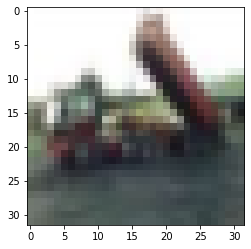

In [96]:
plt.imshow(ex)
plt.show()

In [100]:
trainloader = torch.utils.data.DataLoader(databatch1, batch_size=4,
                                          shuffle=True, num_workers=0)

In [27]:
db = ImageDataset(trainloader, trainloader)

TypeError: unhashable type: 'list'

In [102]:
db.show_batch()

ValueError: too many values to unpack (expected 2)